In [1]:
from torch import nn
from abc import abstractmethod
from typing import List, Callable, Union, Any, TypeVar, Tuple
# from torch import tensor as Tensor

Tensor = TypeVar('torch.tensor')

class BaseVAE(nn.Module):
    
    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size:int, current_device: int, **kwargs) -> Tensor:
        raise RuntimeWarning()

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass

In [2]:

import torch
from torch import nn
from torch.nn import functional as F

class VanillaVAE(BaseVAE):


    def __init__(self,
                 in_features: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim

        if hidden_dims is None:
            hidden_dims = [128, 64, 32]


        # Build Encoder
        modules = []
        
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Linear(in_features=in_features, out_features=h_dim),
                    nn.LeakyReLU())
            )
            in_features = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1], latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1])

        hidden_dims.reverse() #数组反转
        in_features = hidden_dims[0]
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Linear(in_features=in_features, out_features=h_dim),
                    nn.LeakyReLU())
            )
            in_features = h_dim
            

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=2),
            nn.Tanh())
        

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N']
        recons_loss =F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return [loss, recons_loss, -kld_loss]

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

   

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np

from torch.nn import functional as F
from tqdm import tqdm
# 定义数据集类
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)
# 加载数据
kdTree = torch.load("./static/data/CIFAR10/2D_kdTree/2D_kdTree_50000.pt")
data = kdTree.data
# 对数据进行归一化处理，使其均值为0，方差为1
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)

dataset = MyDataset(torch.tensor(data, dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


In [4]:
num_epochs = 3000
batch_size = 128
learning_rate = 5e-4
device = torch.device('cuda:1')
kl_alf=0.01

vae = VanillaVAE(in_features=2, latent_dim=2).to(device)
vae.train()
optimizer = torch.optim.Adam(vae.parameters(), lr=0.005)

In [6]:
num_epochs = tqdm(range(100))
for epoch in num_epochs:
    all_loss = 0
    all_reconst_loss = 0
    all_kl_loss = 0
    for inputs in dataloader:
        inputs = inputs.to(device)
        recons, inputs, mu, log_var = vae(inputs)
        loss, reconst_loss, kl_loss= vae.loss_function(recons, inputs, mu, log_var, M_N=kl_alf)
        all_loss += loss
        all_reconst_loss += reconst_loss
        all_kl_loss += kl_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    txt = f"all_loss: {all_loss:.4f}, all_reconst_loss: {all_reconst_loss:.4f}, all_kl_loss: {all_kl_loss:.4f}"
    num_epochs.set_description(txt)
    num_epochs.update()


all_loss: 53.5041, all_reconst_loss: 38.9209, all_kl_loss: -1458.3160: 100%|██████████| 100/100 [03:40<00:00,  2.21s/it]


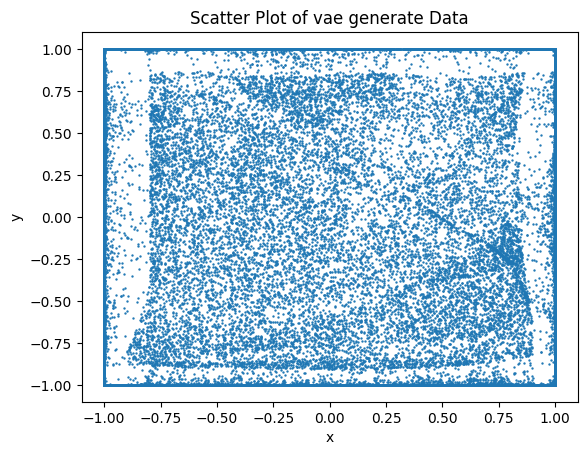

In [7]:
import matplotlib.pyplot as plt
# 生成新数据
vae.eval()
with torch.no_grad():
    x_gen = vae.sample(50000, device).cpu().numpy()

plt.scatter(x_gen[:, 0], x_gen[:, 1], s=0.5)
# 添加坐标轴标签和图标题
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter Plot of vae generate Data')
plt.show()

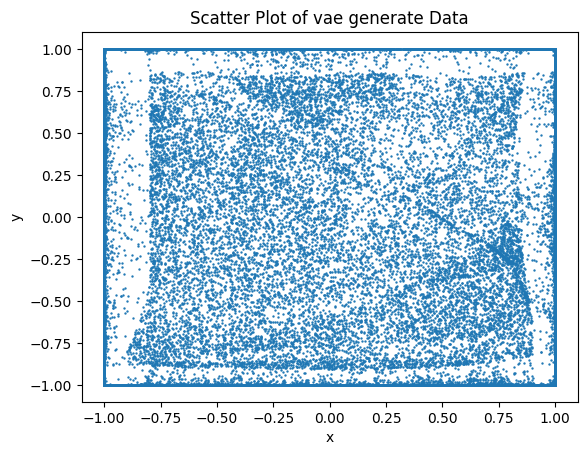

In [8]:
# 之前进行了归一化，现在变回去data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
x_gen = x_gen * np.std(data, axis=0) + np.mean(data, axis=0)
plt.scatter(x_gen[:, 0], x_gen[:, 1], s=0.5)
# 添加坐标轴标签和图标题
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter Plot of vae generate Data')
plt.show()

In [9]:
latent_z_path="./static/data/CIFAR10/latent_z/BigGAN_208z_50000.pt"
latent_z = torch.load(latent_z_path, map_location="cpu") #因为我之前保存数据到了GPU上，所以要回到cpu上才不会出错
from scipy import spatial

In [10]:
def get_zs_prevent_stick(coordinates, kdTree_2D, latent_z, k=10):
    '''
    nearest_distance: n*k维
    nearest_index: n*k维
    dict_zs: 键是文件的id号, 值是对应的z（后面直接改成数组了，问题不大）
    '''
    print("进入了防止粘在一块~~~~~~~~~~~~~~~~~~")
    # 直接一次查询所有坐标的k个近邻
    nearest_distance, nearest_index = kdTree_2D.query(coordinates, k=k)
    origin_coordinates = kdTree_2D.data # 获取kdtree中原始的坐标
    for i, pos in enumerate(coordinates): #对每一个坐标进行插值
        # pos坐标对应的近邻下标
        pos_nearst_index = nearest_index[i] # 其中有k个index，每个index对应kdTree_2D中的一个2维坐标
        pos_nearst_distance = nearest_distance[i]

        # 最近邻的坐标点，以及最近的距离
        most_nearst_pos = origin_coordinates[pos_nearst_index[0]]
        most_nearst_dis = pos_nearst_distance[0]

        # 利用三角形,找到第二个插值基点，让两边之和越接近第三边，就越是钝角，就越合理
        s1 = most_nearst_dis
        best_index = 1 # 默认第二个最近邻最好
        min_dif = 100
        for j in range(1, k):
            cur_pos = origin_coordinates[pos_nearst_index[j]]
            s2 = pos_nearst_distance[j]
            s3 = np.linalg.norm(most_nearst_pos-cur_pos)
            if (s1 + s2) - s3 < min_dif: # 两边之和大于等于第三边，所以不用绝对值
                min_dif = (s1 + s2) - s3
                best_index = j
        
        temp_z_0 = latent_z[pos_nearst_index[0]].clone().detach()
        temp_z_1 = latent_z[pos_nearst_index[best_index]].clone().detach()
        sum_distance = most_nearst_dis + pos_nearst_distance[best_index]
        z_new = (sum_distance-most_nearst_dis)/(sum_distance) * temp_z_0 + (sum_distance-pos_nearst_distance[best_index])/(sum_distance) * temp_z_1

        z_new = z_new.unsqueeze(0)
        if i == 0:
            zs = z_new
        else:
            zs = torch.cat((zs, z_new), dim=0)

    return zs

In [11]:
zs = get_zs_prevent_stick(x_gen, kdTree, latent_z)

进入了防止粘在一块~~~~~~~~~~~~~~~~~~


KeyboardInterrupt: 

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# 用来处理zs的类，方便使用batchsize
class Mydata_sets(Dataset):
    
    def __init__(self, zs):
        super(Mydata_sets, self).__init__()
        self.zs = zs

    def __getitem__(self, index):
        z = self.zs[index]
        return z

    def __len__(self):
        return len(self.zs)
        
zs_datasets = Mydata_sets(zs)
zs_loader = DataLoader(zs_datasets, batch_size=200, shuffle=False, num_workers=1)
model_files_dir = "./model_files/" # 模型位置
sys.path.append(model_files_dir)
import model_files as model_all
checkpoints_path = "./model_files/CIFAR10/checkpoints/BigGAN/model=G-best-weights-step=162000.pth"
device = torch.device("cuda:0")
G = model_all.get_generative_model("CIFAR10").to(device)
G.load_state_dict(torch.load(checkpoints_path, map_location=device)["state_dict"])
G.eval()
print()

In [ ]:
import torchvision.transforms as transforms
import torchvision.utils as utils

transform = transforms.Compose(
        [
            transforms.Normalize([0.4914,0.4822,0.4465], [0.2023,0.1994,0.2010])
        ]
    )

first = 0 # 判断是否第一次进入循环
count = 0
with torch.no_grad(): # 取消梯度计算，加快运行速度
    for batch_z in zs_loader: 
        z = torch.tensor(batch_z).to(torch.float32).to(device)    # latent code
        imgs = G(z)   
        for i, img in enumerate(imgs):
            img = ((img + 1)/2).clamp(0.0, 1.0) # 变换到[0,1]范围内
            utils.save_image(img.detach().cpu(), f'./临时垃圾-随时可删/sample2D_50k/pic{count}.jpg')
            count += 1

/home/kuangjielong/.conda/envs/python3_7/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [ ]:
import sys
python_files_dir = "./python_files/" # python工具包位置
sys.path.append(python_files_dir)
import fid_score as official_fid
# fid计算模型
dims = 2048
batch_size = 1
num_avail_cpus = len(os.sched_getaffinity(0))
num_workers = min(num_avail_cpus, 8)
block_idx = official_fid.InceptionV3.BLOCK_INDEX_BY_DIM[2048]
fid_model = official_fid.InceptionV3([block_idx]).to(device)
print('fid_model load success!')


pic_path_fid1 = './临时垃圾-随时可删/sample2D_50k/'
pic_path_fid2 = './static/data/CIFAR10/pic/random_50k'
    
batch_size = 100
m1, s1 = official_fid.compute_statistics_of_path(pic_path_fid1, fid_model, batch_size,
                                    dims, device, num_workers)
m2, s2 = official_fid.compute_statistics_of_path(pic_path_fid2, fid_model, batch_size,
                                    dims, device, num_workers)
fid_value=official_fid.calculate_frechet_distance(m1,s1,m2,s2) 
print(fid_value)